In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgbm

from tfg_module import my_get_time_series as mgts
from tfg_module import my_process_data as mpd
from tfg_module import my_future as mf

In [2]:
model_name = 'LigthGBM'
TARGET = 'Compras' # target can be either Ventas or Compras

In [3]:
ts = mgts.get_ts(TARGET)
ts

,date,Compras
0,2017-09-30,"6,865"
1,2017-10-31,"5,452"
2,2017-11-30,"4,399"
3,2017-12-31,"37,490"
4,2018-01-31,"4,486"
...,...,...
72,2023-09-30,"7,394"
73,2023-10-31,"28,417"
74,2023-11-30,"14,432"
75,2023-12-31,"27,198"


In [4]:
X, y = mpd.create_features(ts.copy(), target = TARGET, informer = False)

In [5]:
cross_val_split = TimeSeriesSplit(n_splits=3, test_size=20)
model_LGBM = lgbm.LGBMRegressor(verbosity = -1)
params_grid = {
            'max_depth': [3,5,10],
            'num_leaves': [10, 20, 30]#,
            # 'learning_rate': [0.1, 0.01],
            # 'n_estimators': [50, 500, 1000],
            # 'colsample_bytree': [0.3,  0.7],
            # 'objective': ['binary'],
            # 'boosting_type': ['rf'],
            # 'num_leaves': [5],
            # 'force_row_wise': [True],
            # 'learning_rate': [0.5],
            # 'metric': ['binary_logloss'],
            # 'bagging_fraction': [0.8],
            # 'feature_fraction': [0.8],
            # 'num_round' = [500]  
        }
metrics_to_keep = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']
best_model_LGBM = GridSearchCV(estimator = model_LGBM, cv=cross_val_split, param_grid=params_grid, 
                          scoring = metrics_to_keep,
                          refit = 'neg_mean_absolute_error')

In [6]:
best_model_LGBM.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=20),
             estimator=LGBMRegressor(verbosity=-1),
             param_grid={'max_depth': [3, 5, 10], 'num_leaves': [10, 20, 30]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])

In [7]:
results = best_model_LGBM.cv_results_

In [8]:
opposite_metric = {'neg_mean_absolute_error':'neg_root_mean_squared_error',
                   'neg_root_mean_squared_error':'neg_mean_absolute_error'}

In [9]:
models_by_metric = {}
for metric in metrics_to_keep:
    best_index = results[f'rank_test_{metric}'].argmin()
    best_score = results[f'mean_test_{metric}'][best_index]*-1
    other_metric_score = results[f'mean_test_{opposite_metric[metric]}'][best_index]*-1
    best_params = results['params'][best_index]
    best_model = lgbm.LGBMRegressor(**best_params, verbosity = -1)
    best_model.fit(X,y)
    if metric == 'neg_mean_absolute_error':
        models_by_metric[metric] = (best_model, best_params, best_score, other_metric_score)
    else:
        models_by_metric[metric] = (best_model, best_params, other_metric_score, best_score)

best_lgbm_models_df = pd.DataFrame(models_by_metric)
best_lgbm_models_df.rename(columns = {'neg_mean_absolute_error':'best_MAE', 'neg_root_mean_squared_error':'best_RMSE'}, inplace = True)
best_lgbm_models_df.index = ['model', 'parameters', 'mae', 'rmse']

In [10]:
best_lgbm_models_df

,best_MAE,best_RMSE
model,"LGBMRegressor(max_depth=3, num_leaves=10, verb...","LGBMRegressor(max_depth=3, num_leaves=10, verb..."
parameters,"{'max_depth': 3, 'num_leaves': 10}","{'max_depth': 3, 'num_leaves': 10}"
mae,"8,054","8,054"
rmse,"10,409","10,409"


In [11]:
best_mae_model = best_lgbm_models_df.loc['model','best_MAE']
best_mae_model

LGBMRegressor(max_depth=3, num_leaves=10, verbosity=-1)

In [12]:
best_mae_df = mf.get_pred_df(ts, best_mae_model)
best_mae_df

,date,pred
0,2024-01-31,"11,007"
1,2024-02-29,"10,408"
2,2024-03-31,"14,049"
3,2024-04-30,"10,408"
4,2024-05-31,"14,049"
5,2024-06-30,"14,054"
6,2024-07-31,"22,451"
7,2024-08-31,"17,118"
8,2024-09-30,"9,441"
9,2024-10-31,"22,296"


save: mae


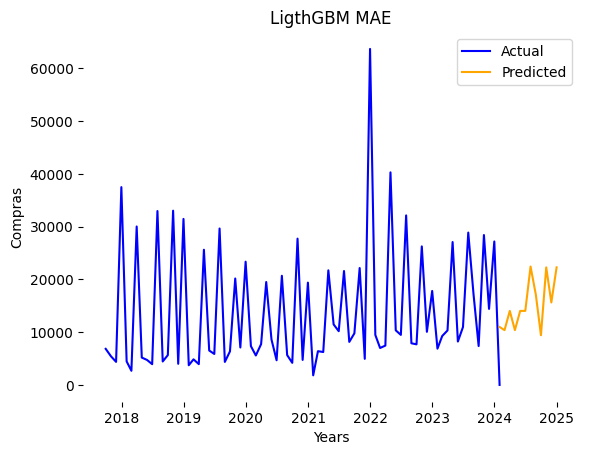

In [13]:
mf.save_pred_plot(model_name, ts, best_mae_df, 'mae')

In [14]:
best_rmse_model = best_lgbm_models_df.loc['model','best_RMSE']
best_rmse_model

LGBMRegressor(max_depth=3, num_leaves=10, verbosity=-1)

In [15]:
best_rmse_df = mf.get_pred_df(ts, best_rmse_model)
best_rmse_df

,date,pred
0,2024-01-31,"11,007"
1,2024-02-29,"10,408"
2,2024-03-31,"14,049"
3,2024-04-30,"10,408"
4,2024-05-31,"14,049"
5,2024-06-30,"14,054"
6,2024-07-31,"22,451"
7,2024-08-31,"17,118"
8,2024-09-30,"9,441"
9,2024-10-31,"22,296"


save: mse


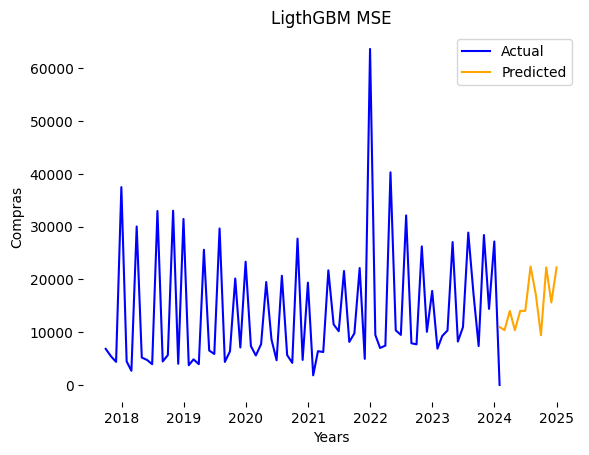

In [16]:
mf.save_pred_plot(model_name, ts, best_rmse_df, 'mse')